In [1]:
import colorsys
from typing import Iterable, Tuple

import numpy as np
from IPython.display import display
from PIL import Image

In [2]:
def rgb2hsl_fn(x):
    return colorsys.rgb_to_hls(*x)


def rgb2hsl(arr):
    w, h, d = arr.shape
    assert d == 3
    return np.apply_along_axis(rgb2hsl_fn, 1, arr.reshape(-1, 3)).reshape(w, h, 3)


def hsl2rgb_fn(x):
    return colorsys.hls_to_rgb(*x)


def hsl2rgb(arr):
    w, h, d = arr.shape
    assert d == 3
    return np.apply_along_axis(hsl2rgb_fn, 1, arr.reshape(-1, 3)).reshape(w, h, 3)

# Simulate Images and Survival Data

Generate images with black square of different hue determining the risk score.

In [3]:
class ImageGenerator:
    def __init__(self, img_size = (28, 28)) -> None:
        self.img_size = img_size
        self.length = 10
        self.seed = 34734

    def _set_random_rectangle(self, img: np.ndarray, color: float, random: np.random.RandomState) -> np.ndarray:
        x = random.randint(self.length, self.img_size[0])
        y = random.randint(self.img_size[1] - self.length)

        img[x - self.length : x, y : y + self.length, :] = color
        return img

    def make_images(self, num_obs: int) -> Iterable[Tuple[np.ndarray, float]]:
        random = np.random.RandomState(self.seed)

        n_hues = 100
        min_hue = 1
        hue_increment = (360 - min_hue) / n_hues
        hue_values = min_hue + np.arange(n_hues) * hue_increment

        h_idx = random.randint(n_hues, size=num_obs)
        color_h = hue_values[h_idx]

        for h_channel in color_h:
            color_rgb = colorsys.hls_to_rgb(h_channel / 360, 50 / 100, 100 / 100)

            img = np.zeros(self.img_size + (3,), dtype=np.float32)
            img = self._set_random_rectangle(img, color_rgb, random)

            yield img, h_channel

In [4]:
def hue_to_risk_score(hue: np.ndarray) -> np.ndarray:
    min_l = np.min(hue)
    max_l = np.max(hue)

    unit_scaled = (hue + min_l) / (max_l - min_l)
    # rescale to make differences between risk groups larger
    rescale_factor = np.sqrt(2) * np.pi
    return unit_scaled * rescale_factor


class SurvivalGenerator:
    def __init__(self, mean_survival_time: float = 20.0) -> None:
        self.mean_survival_time = mean_survival_time
        self.seed = 34734
        self.quantile_censored = 0.925  # determines the amount of censoring

    def make_survival_time(self, riskscores: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        random = np.random.RandomState(self.seed)

        baseline_hazard = 1.0 / self.mean_survival_time
        scale = baseline_hazard * np.exp(riskscores)
        u = random.uniform(low=0, high=1, size=riskscores.shape[0])
        t = -np.log(u) / scale

        # generate time of censoring
        qt = np.quantile(t, self.quantile_censored)
        c = random.uniform(low=t.min(), high=qt)

        observed_event = t <= c
        observed_time = np.where(observed_event, t, c)
        return observed_time, observed_event

In [5]:
img_gen = ImageGenerator()
images = []
hues = []
for arr, hue in img_gen.make_images(10000):
    img = Image.fromarray((arr * 255).astype(np.uint8), mode="RGB")
    images.append(img)
    hues.append(hue)

for img in images[:10]:
    display(img)

del arr, hue, img, img_gen

In [6]:
risk_scores = hue_to_risk_score(hues)

surv_gen = SurvivalGenerator()
surv_time, surv_status = surv_gen.make_survival_time(risk_scores)

print("Percentage of events:", surv_status.mean())

del surv_gen

Percentage of events: 0.4918


## Plot overall survival function

(0.0, 1.0)

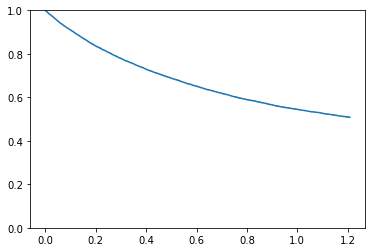

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

from sksurv.nonparametric import kaplan_meier_estimator

x, y = kaplan_meier_estimator(surv_status, surv_time)
plt.step(x, y, where="post")
plt.ylim(0, 1)

Performance with true risk scores.

In [8]:
from sksurv.metrics import concordance_index_ipcw
from sksurv.util import Surv

In [9]:
y = Surv.from_arrays(event=surv_status, time=surv_time)
cindex_known = concordance_index_ipcw(y, y, risk_scores)
print(cindex_known)

(0.7867546831763486, 29017135, 7749011, 318033, 0)


In [10]:
risk_scores.max()

4.467884389654714

# Create CNN

In [11]:
import torch
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm

from losses import CoxphLoss
from models import MyCNN
from surv_data import cox_collate_fn

In [12]:
class SimulationData(Dataset):

    def __init__(self, data):
        self.data = data
        self._image_transform = transforms.ToTensor()

    def __getitem__(self, index):
        img, event, time = self.data[index]
        return self._image_transform(img), torch.tensor([event], dtype=torch.int8), torch.tensor(time, dtype=torch.float)

    def __len__(self):
        return len(self.data)

    @property
    def event(self):
        return np.array([d[1] for d in self.data])

    @property
    def time(self):
        return np.array([d[2] for d in self.data])

### Create train and test datasets

In [13]:
train_idx, test_idx = train_test_split(np.arange(len(images)), stratify=surv_status, test_size=0.2, random_state=0)

train_data = SimulationData([(images[i], surv_status[i], surv_time[i]) for i in train_idx])
test_data = SimulationData([(images[i], surv_status[i], surv_time[i]) for i in test_idx])

train_loader = DataLoader(
    train_data,
    collate_fn=cox_collate_fn,
    pin_memory=True,
    batch_size=256,
    shuffle=True,
    drop_last=True,
    num_workers=4,
)
test_loader = DataLoader(
    test_data,
    collate_fn=cox_collate_fn,
    pin_memory=True,
    batch_size=256,
)

### Train the model

In [14]:
device = torch.device("cuda")
model = MyCNN(1)
model = model.to(device)
print(model)

criterion = CoxphLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 95], gamma=0.2)
model.train()

pbar = tqdm(range(100), total=100)
for epoch in pbar:
    mean_loss = 0.0
    for batch_img, batch_event, batch_time, batch_riskset in train_loader:
        batch_img = batch_img.to(device)
        batch_event = batch_event.to(device)
        batch_riskset = batch_riskset.to(device)

        logits = model(batch_img)
        loss = criterion(logits, batch_event, batch_riskset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        mean_loss += loss.item()
    mean_loss /= len(train_loader)
    pbar.set_postfix({"loss": mean_loss})
    pbar.update()

del batch_img, batch_event, batch_time, batch_riskset, pbar, criterion, loss, logits, mean_loss, optimizer, scheduler

MyCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1_relu): ReLU()
  (conv1_s): Conv2d(6, 6, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_relu): ReLU()
  (conv2_s): Conv2d(16, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (flatten): Flatten()
  (dense1): Linear(in_features=576, out_features=120, bias=True)
  (dense1_relu): ReLU()
  (dense2): Linear(in_features=120, out_features=84, bias=True)
  (dense2_relu): ReLU()
  (dense3): Linear(in_features=84, out_features=1, bias=False)
)


### Evaluate the model

In [15]:
model = model.eval()

pred_risk_scores = []
with torch.no_grad():
    for batch_img, batch_event, batch_time, batch_riskset in test_loader:
        batch_img = batch_img.to(device)

        logits = model(batch_img)
        pred_risk_scores.append(logits.squeeze(1).detach().cpu().numpy())

pred_risk_scores = np.concatenate(pred_risk_scores)

del batch_img, batch_event, batch_time, batch_riskset, logits

Compare performance of CNN-predicted risk scores to performance on ground truth risk scores.

In [16]:
test_y = Surv.from_arrays(event=test_loader.dataset.event, time=test_loader.dataset.time)
cindex_pred = concordance_index_ipcw(y, test_y, pred_risk_scores)
print(cindex_pred[0], cindex_known[0])

0.7759360379673449 0.7867546831763486


# Attribution

**The baseline is an all black image (zeros).**

Compute the difference we are going to explain.

In [26]:
explain_loader = DataLoader(
    [test_data[i] for i in range(5)],  # take first 5 samples of test data
    collate_fn=cox_collate_fn,
    pin_memory=True,
    batch_size=5,
)

In [18]:
model = model.eval()
with torch.no_grad():
    baseline = torch.zeros(1, 3, 28, 28, device=device)
    baseline_pred = model(baseline).squeeze().detach().cpu().numpy()

# the difference SV explains: prediction(true image) - prediction(baseline_image)
explain_delta = pred_risk_scores[:explain_loader.batch_size] - baseline_pred

## Shapley Value Sampling

> E. Štrumbelj and I. Kononenko, “Explaining prediction models and individual predictions with feature contributions,” Knowl. Inf. Syst., vol. 41, no. 3, pp. 647–665, Dec. 2014. [10.1007/s10115-013-0679-x](https://doi.org/10.1007/s10115-013-0679-x)

In [19]:
def explain_sv_sampling(
    model: nn.Module,
    img_height: int,
    img_width: int,
    explain_loader: DataLoader,
    n_steps: int = 1000
) -> np.ndarray:
    batch_size = explain_loader.batch_size

    model = model.eval()

    n_players =  img_height * img_width
    pbar = tqdm(total=n_steps * n_players)
    with torch.no_grad():
        baseline = torch.zeros(1, 3, img_height, img_width, device=device).expand(
            batch_size, -1, -1, -1)

        # only use the first batch
        batch = next(iter(explain_loader))
        img = batch[0].to(device)

        attributions = np.zeros(
            (batch_size, img_height, img_width, 1), dtype=float
        )
        for _ in range(n_steps):
            perm = torch.randperm(n_players, device=device)
            img_in = baseline.repeat(2, 1, 1, 1)
            for end in range(n_players):
                idx = perm[end]
                # img_in already includes real values that come before `j` in `perm`
                # only need to add current point to first half
                i, j = np.unravel_index(idx.detach().cpu().numpy(), (img_height, img_width))
                img_in[:batch_size, :, i, j] = img[..., i, j]

                pred = model(img_in)
                pred_w_i, pred_wo_i = torch.chunk(pred, 2)
                delta = pred_w_i - pred_wo_i

                attributions[:, i, j] += delta.detach().cpu().numpy()

                # add current point to second half, such that both parts are equal
                img_in[batch_size:, :, i, j] = img[..., i, j]

                pbar.update()

        attributions /= n_steps

    return attributions

In [20]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


def pil_image_iterator(data_loader):
    with torch.no_grad():
        convert_img = transforms.ToPILImage()
        for batch_img, batch_event, batch_time, batch_riskset in data_loader:
            for i in range(data_loader.batch_size):
                img = convert_img(batch_img[i])
                yield img


def attributions_to_image(attributions):
    assert attributions.ndim == 3
    # map SV to RGBA
    mapper = ScalarMappable(
        Normalize(vmin=attributions.min(), vmax=attributions.max()),
        cmap="inferno"
    )
    images = tuple(
        Image.fromarray(mapper.to_rgba(attr, bytes=True), mode="RGBA")
        for attr in attributions
    )
    return images

⚠⚠⚠ **THIS WILL TAKE TIME** ⚠⚠⚠

In [21]:
sv_sampling = explain_sv_sampling(model, 28, 28, explain_loader)

Display heatmaps.

In [22]:
for sv, sv_image, input_image, delta in zip(
    sv_sampling.squeeze(-1),
    attributions_to_image(sv_sampling.squeeze(-1)),
    pil_image_iterator(explain_loader),
    explain_delta
):
    display(input_image)
    display(sv_image)
    print("Completness Δ =", np.absolute(sv.sum() - delta))

del sv, sv_image, input_image, delta 

Completness Δ = 0.0


Completness Δ = 0.0


Completness Δ = 2.0816681711721685e-17


Completness Δ = 0.0


Completness Δ = 0.0


## Integrated Gradients

> M. Sundararajan, A. Taly, and Q. Yan, “Axiomatic Attribution for Deep Networks,” in Proceedings of the 34th International Conference on Machine Learning, 2017, pp. 3319--3328. http://arxiv.org/abs/1703.01365

$$
(x_i - x_i^\prime) \cdot \frac{1}{m} \sum_{k=1}^m \frac{ \partial F(x^\prime + \frac{k}{m} (x - x^\prime)) }
{ \partial x_i }
$$

In [36]:
def integrated_gradients(
    model: nn.Module,
    explain_loader: DataLoader,
    n_steps: int = 100,
    output_idx: int = 0
) -> np.ndarray:
    model = model.eval()
    batch_size = explain_loader.batch_size

    baseline = torch.zeros(1, 3, 28, 28, device=device)
    alphas = torch.linspace(0, 1, n_steps, device=device).view(-1, 1, 1, 1)

    # only use the first batch
    batch = next(iter(explain_loader))
    img = batch[0].to(device)

    inputs = tuple(
        (xp.unsqueeze(dim=0) + (x - xp).unsqueeze(dim=0) * alphas).requires_grad_()  # shape = n_steps, 3, 28, 28
        for x, xp in zip(img, baseline.expand_as(img))
    )

    with torch.autograd.set_grad_enabled(True):
        outputs = model(torch.cat(inputs, dim=0))
        # Computes and returns the sum of gradients of outputs w.r.t. the inputs
        grads = torch.autograd.grad(torch.unbind(outputs[:, output_idx]), inputs)

    assert len(grads) == batch_size
    assert grads[0].size()[0] == n_steps

    img_baseline_diff = img - baseline  # shape (batch_size, 3, 28, 28)
    # average over alphas
    attributions = torch.stack([grad.mean(dim=0) for grad in grads])
    attributions *= img_baseline_diff
    attributions = attributions.detach().cpu().numpy()
    
    return attributions

In [37]:
ig_attributions = integrated_gradients(model, explain_loader, n_steps=10000)
ig_attributions = ig_attributions.sum(axis=1)  # sum over channel dimension

Display heatmaps.

In [38]:
for ig, ig_image, input_image, delta in zip(
    ig_attributions,
    attributions_to_image(ig_attributions),
    pil_image_iterator(explain_loader),
    explain_delta
):
    display(input_image)
    display(ig_image)
    print("Completness Δ =", np.absolute(ig.sum() - delta))
    
del ig, ig_image, input_image, delta

Completness Δ = 0.000495702


Completness Δ = 0.0013535023


Completness Δ = 0.00046651438


Completness Δ = 0.0006260872


Completness Δ = 0.0007176399
